In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        # Implement this!
        if np.random.choice(range(2), p=[epsilon, 1-epsilon]):
            action = np.argmax(Q[observation])
        else:
            action = np.random.randint(nA)
        return np.eye(nA)[action]
        
    return policy_fn

In [18]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for t in range(num_episodes):
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
            
        s_a_in_episode = set([(x[0], x[1]) for x in episode])
        for state, action in s_a_in_episode:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] for x in episode[first_occurence_idx:]])
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1.0
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
    
    return Q, policy

In [19]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

dict_items([((18, 6, False), 0.27081967213114755), ((13, 2, False), -0.28836346777932315), ((17, 8, True), -0.076388888888888895), ((20, 6, False), 0.71560251798561147), ((13, 1, False), -0.56544378698224851), ((12, 10, True), -0.17050691244239632), ((21, 3, True), 0.88586437440305632), ((12, 5, True), 0.12328767123287671), ((14, 2, True), 0.027334851936218679), ((14, 1, True), -0.39540229885057471), ((16, 4, True), 0.070567986230636828), ((16, 7, True), -0.062977099236641215), ((14, 4, False), -0.22002141327623126), ((14, 6, True), -0.12955465587044535), ((13, 7, False), -0.30719762552559982), ((12, 6, False), -0.16487455197132617), ((19, 10, False), -0.0076869322152341019), ((15, 7, False), -0.37924101533048504), ((17, 5, False), -0.056333545512412479), ((13, 10, False), -0.4744366652938754), ((16, 1, True), -0.40000000000000002), ((19, 9, False), 0.27596439169139464), ((20, 9, True), 0.77091377091377089), ((19, 4, False), 0.36702954898911355), ((17, 3, False), -0.11326468806783767),

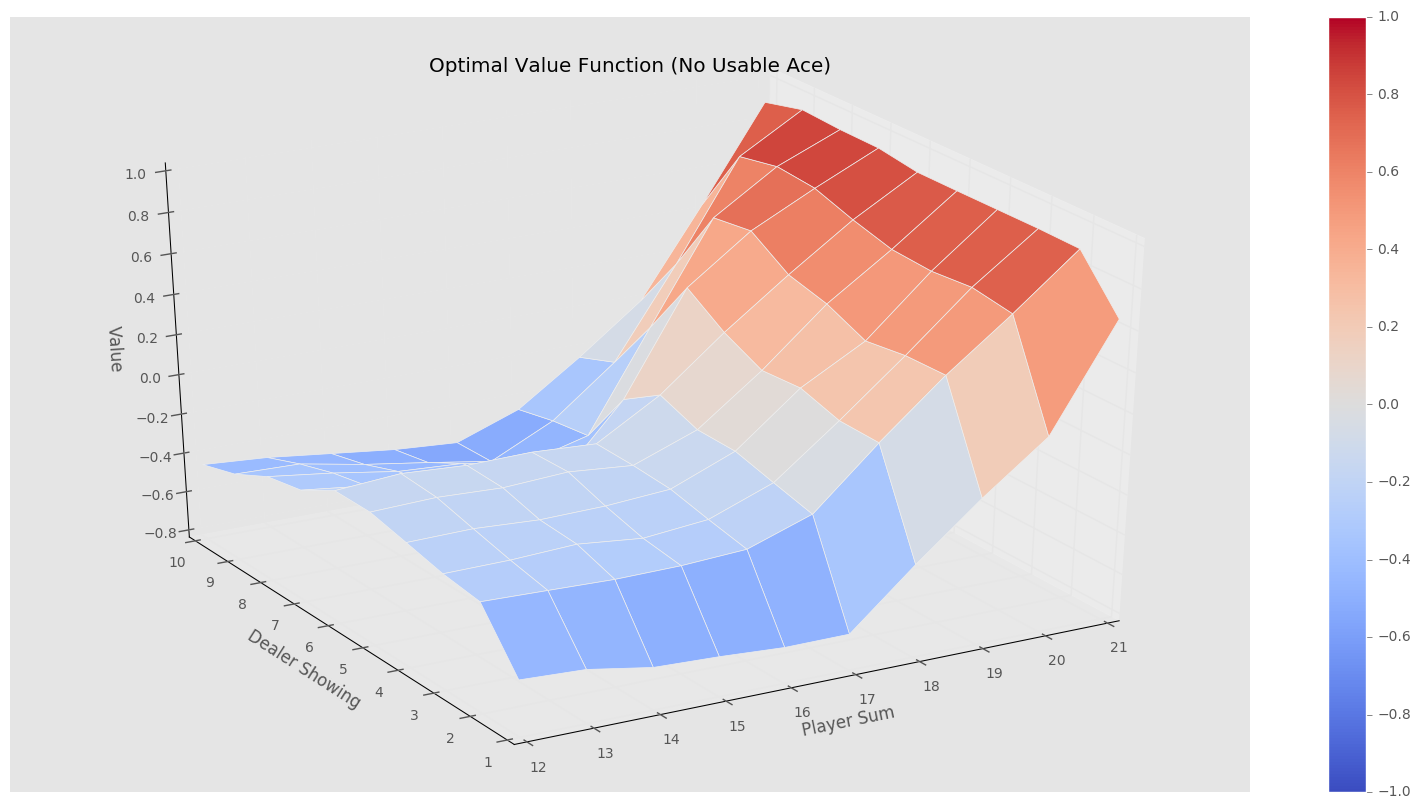

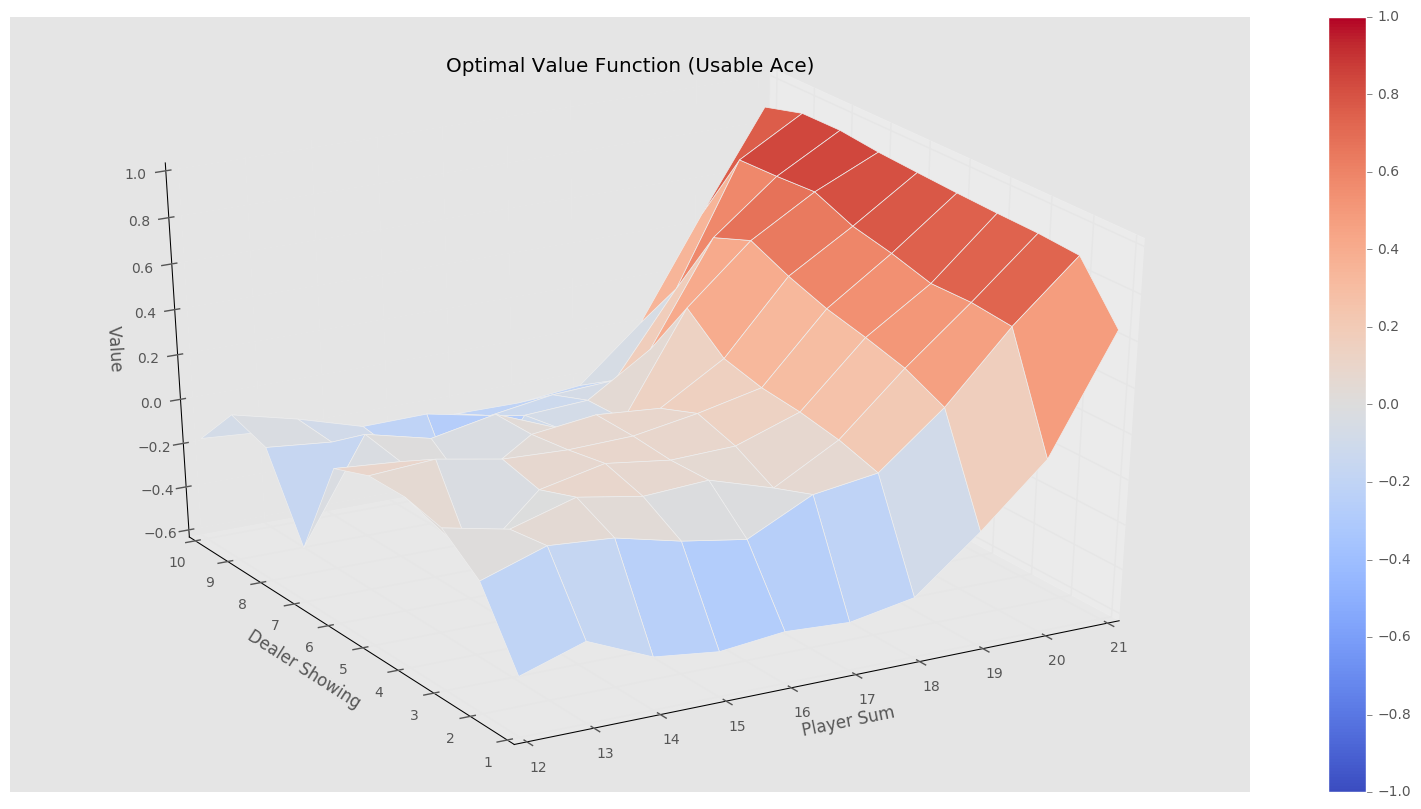

In [20]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
print V.viewitems()


plotting.plot_value_function(V, title="Optimal Value Function")